In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unicodedata
import nltk
import csv
import string
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import transformers
import warnings
import operator
import os
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import gensim


/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
from torchtext import data
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from sklearn.metrics import jaccard_score
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
from gensim import utils
from matplotlib.ticker import StrMethodFormatter
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/tmp/ipykernel_11719/1340711202.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [3]:
%matplotlib inline
pd.options.display.max_colwidth = 250
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/slava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())
        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            pad_to_max_length = True,
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [8]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 10)

    def forward(self, ids, mask, token_type_ids, return_dict=False):
        unw, out_1 = self.layer1(ids, attention_mask=mask, token_type_ids=token_type_ids)[0], self.layer1(ids, attention_mask=mask, token_type_ids=token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

In [9]:
bert = torch.load("bertmodel.pth", map_location=torch.device('cpu'))
bert

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [7]:
model = BERT()
model.to(device)

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [8]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 10)

    def forward(self, ids, mask, token_type_ids, return_dict=False):
        unw, out_1 = self.layer1(ids, attention_mask=mask, token_type_ids=token_type_ids)[0], self.layer1(ids, attention_mask=mask, token_type_ids=token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

In [9]:
model = BERT()
model.to(device)

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [10]:
bert = torch.load("bertmodel.pth", map_location=torch.device('cpu'))
bert

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [13]:
torch.save(model.state_dict(), 'weights_only.pth')

In [14]:
model_new = BERT()
model_new.to(device)
model_new.load_state_dict(torch.load('weights_only.pth'))
model_new

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [15]:
def test():
    bert.eval()
    bert_outputs = []
    with torch.no_grad():
        for unw, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = bert(ids, mask, token_type_ids)
            bert_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return bert_outputs

In [16]:
texts_path = '../Georgian Texts/Vazha Pshavela/'
sources = ['en/', 'ggl/', 'gem/', 'gpt/']
poems_path = texts_path + 'Poems/revised/'
poem_names = []

ge_poems_directory = os.fsencode(poems_path + 'ge/')
for file in sorted(os.listdir(ge_poems_directory)):
    poem_names.append(file.decode())

In [17]:
for source in sources:
    for poem in poem_names:
        poem_text = [line.strip() for line in open(poems_path + source + poem, "r")]
        poem_df = pd.DataFrame(poem_text, columns=['Tweet'])
        poem_df['list'] = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(poem_text)

        test_dataset = CustomDataset(poem_df, tokenizer, MAX_LEN)
        bert_test_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
        test_loader = DataLoader(test_dataset, **bert_test_params)
        test_outputs = test()
        test_outputs = np.array(test_outputs)

        for i in range(test_outputs.shape[0]):
            for j in range(test_outputs.shape[1]):
                if test_outputs[i][j] >= 0.5:
                    test_outputs[i][j] = 1
                else:
                    test_outputs[i][j] = 0

        poem_df['Optimistic'] = "None"
        poem_df['Thankful'] = "None"
        poem_df['Empathetic'] = "None"
        poem_df['Pessimistic'] = "None"
        poem_df['Anxious'] = "None"
        poem_df['Sad'] = "None"
        poem_df['Annoyed'] = "None"
        poem_df['Denial'] = "None"
        poem_df['Official report'] = "None"
        poem_df['Joking'] = "None"
        poem_df = poem_df.drop(['list'], axis=1)

        for i in range(len(test_outputs)):
            poem_df['Optimistic'].iloc[i] = test_outputs[i][0]
            poem_df['Thankful'].iloc[i] = test_outputs[i][1]
            poem_df['Empathetic'].iloc[i] = test_outputs[i][2]
            poem_df['Pessimistic'].iloc[i] = test_outputs[i][3]
            poem_df['Anxious'].iloc[i] = test_outputs[i][4]
            poem_df['Sad'].iloc[i] = test_outputs[i][5]
            poem_df['Annoyed'].iloc[i] = test_outputs[i][6]
            poem_df['Denial'].iloc[i] = test_outputs[i][7]
            poem_df['Official report'].iloc[i] = test_outputs[i][8]
            poem_df['Joking'].iloc[i] = test_outputs[i][9]

        poem_df.to_csv('sentiment/' + source + poem)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Optimistic'),
  Text(1, 0, 'Thankful'),
  Text(2, 0, 'Empathetic'),
  Text(3, 0, 'Pessimistic'),
  Text(4, 0, 'Anxious'),
  Text(5, 0, 'Sad'),
  Text(6, 0, 'Annoyed'),
  Text(7, 0, 'Denial'),
  Text(8, 0, 'Joking')])

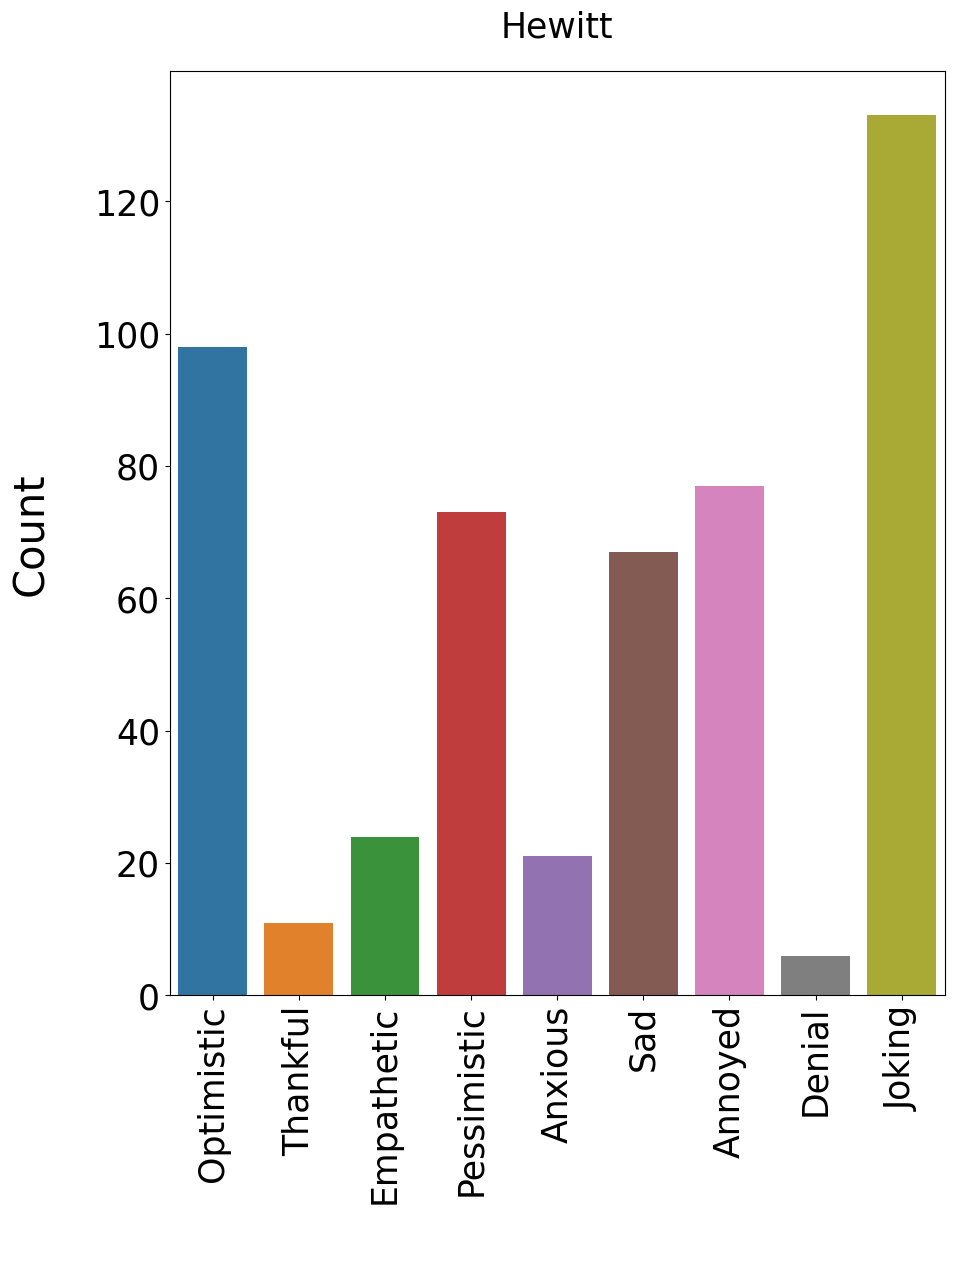

In [19]:
total_df = pd.DataFrame()
for poem in poem_names:
    df = pd.read_csv('sentiment/' + 'en/' + poem)
    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)    

    df = df.iloc[1]
    df = pd.DataFrame(df)
    df.columns = ['Count']
    total_df = pd.concat([total_df, df])

total_df = total_df.reset_index()
total_df = total_df.rename(columns={"index": "Sentiment"})

new_df = pd.DataFrame({
    "Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Joking"], 
    "Count":[0,0,0,0,0,0,0,0,0,]
})

for ii in range(0, 9):
  for jj in range(0, 15):
    new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj * 9 + ii, 'Count']).astype(int)

fig_dims = (10, 12)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x=new_df.Sentiment, y=new_df.Count, ax=ax, palette=sns.color_palette("tab10"))
plt.xticks(rotation=90)
plt.ylabel('Count', labelpad=30)
plt.xlabel(' ')
plt.title('Hewitt', fontsize=25, pad=25)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

In [20]:
def all_chapter_dataframe(source):
    total_df = pd.DataFrame()
    for poem in poem_names:
        df = pd.read_csv('sentiment/' + source + poem)
        df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
        df = df.apply(pd.Series.value_counts)

        df['Optimistic'] = df['Optimistic'].fillna(0)
        df['Thankful'] = df['Thankful'].fillna(0)
        df['Empathetic'] = df['Empathetic'].fillna(0)
        df['Pessimistic'] = df['Pessimistic'].fillna(0)
        df['Anxious'] = df['Anxious'].fillna(0)
        df['Sad'] = df['Sad'].fillna(0)
        df['Annoyed'] = df['Annoyed'].fillna(0)
        df['Denial'] = df['Denial'].fillna(0)
        df['Joking'] = df['Joking'].fillna(0)    

        df = df.iloc[1]
        df = pd.DataFrame(df)
        df.columns = ['Count']
        total_df = pd.concat([total_df, df])

    total_df = total_df.reset_index()
    total_df = total_df.rename(columns={"index": "Sentiment"})

    new_df = pd.DataFrame({
        "Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Joking"], 
        "Count":[0,0,0,0,0,0,0,0,0,]
    })

    for ii in range(0, 9):
        for jj in range(0, 15):
            new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj * 9 + ii, 'Count']).astype(int)
    
    return new_df

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Optimistic'),
  Text(1, 0, 'Thankful'),
  Text(2, 0, 'Empathetic'),
  Text(3, 0, 'Pessimistic'),
  Text(4, 0, 'Anxious'),
  Text(5, 0, 'Sad'),
  Text(6, 0, 'Annoyed'),
  Text(7, 0, 'Denial'),
  Text(8, 0, 'Joking')])

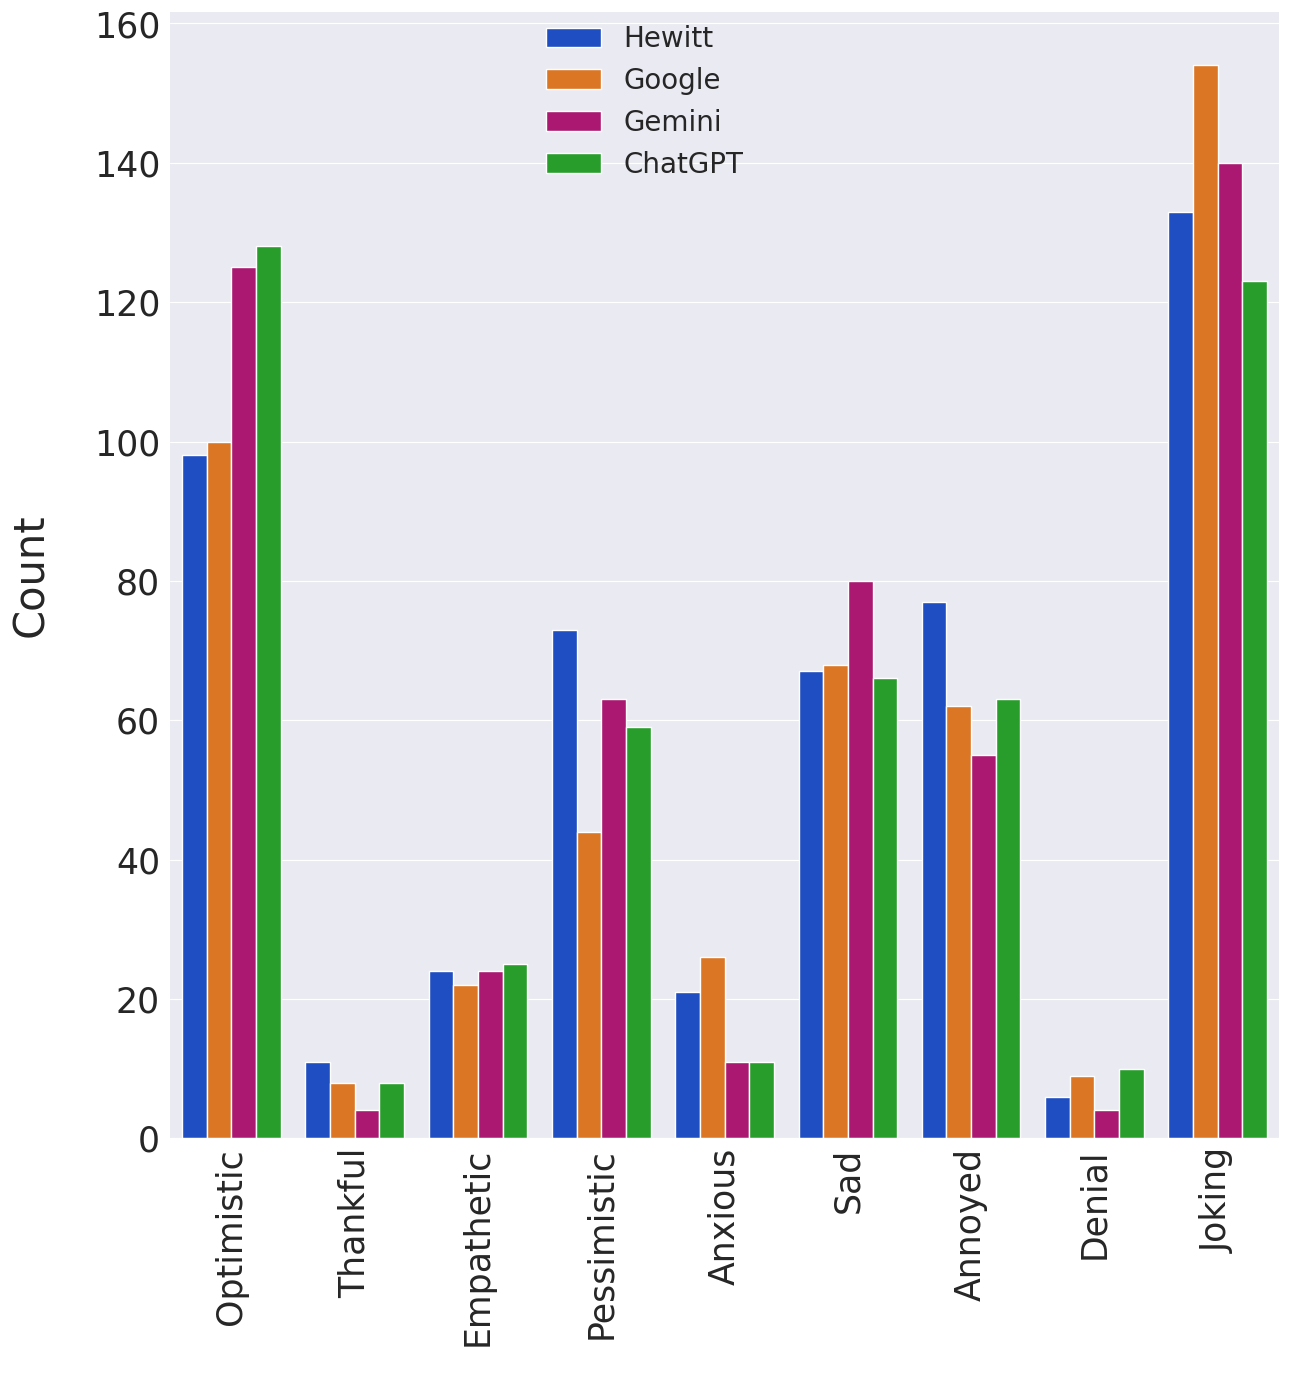

In [21]:
hewitt_sentiment = all_chapter_dataframe('en/')
google_sentiment = all_chapter_dataframe('ggl/')
gemini_sentiment = all_chapter_dataframe('gem/')
chatgpt_sentiment = all_chapter_dataframe('gpt/')

df_new = pd.concat(
    [
        hewitt_sentiment, 
        google_sentiment['Count'], 
        gemini_sentiment['Count'], 
        chatgpt_sentiment['Count']
    ],
    axis=1
)

df_new.columns = ['Sentiment', 'Hewitt', 'Google', 'Gemini', 'ChatGPT']
df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
colors = ["blue", "orange", "magenta", "green"]  
myPalette = sns.xkcd_palette(colors)

sns.set_style("darkgrid")
g = sns.catplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=12, palette=myPalette, legend=True)
g.despine(left=True)
sns.move_legend(g, 'upper center', prop={"size": 20}, title='')
plt.ylabel('Count', labelpad=30, fontsize=30)
plt.xlabel(' ')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)
plt.xticks(rotation=90)

In [22]:
def chapter_wise_dataframe(source, poem):
    df = pd.read_csv('sentiment/' + source + poem)
    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)
    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)
    df = df.iloc[1]
    df = pd.DataFrame(df)
    df.columns = ['Count']
    return df

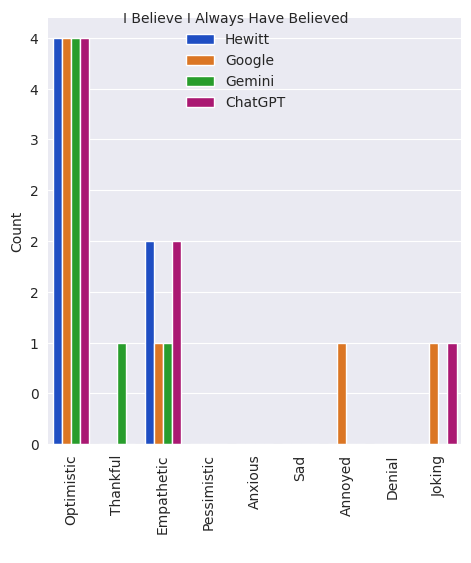

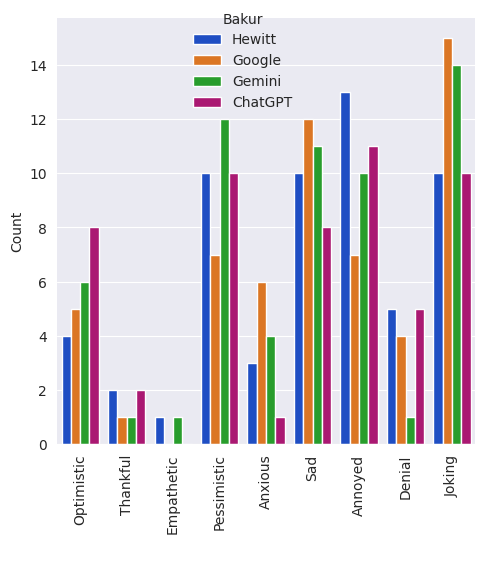

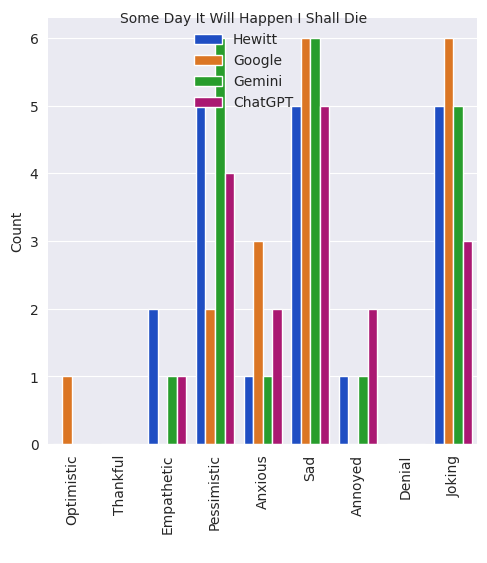

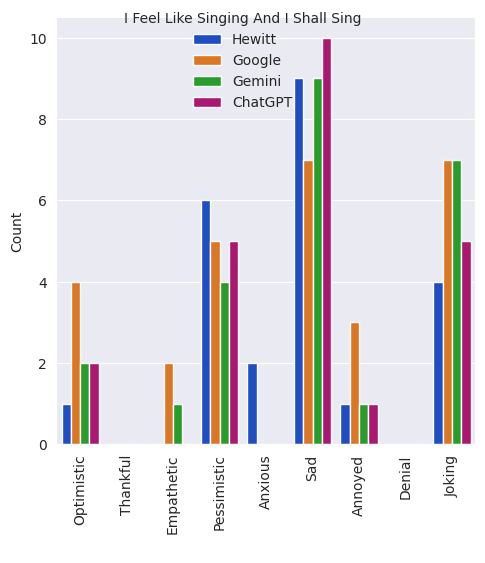

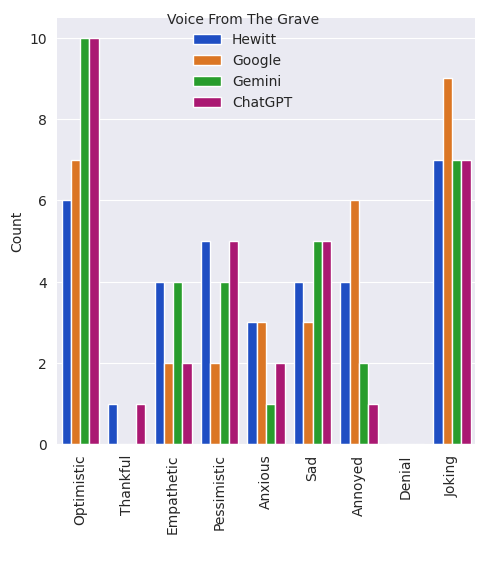

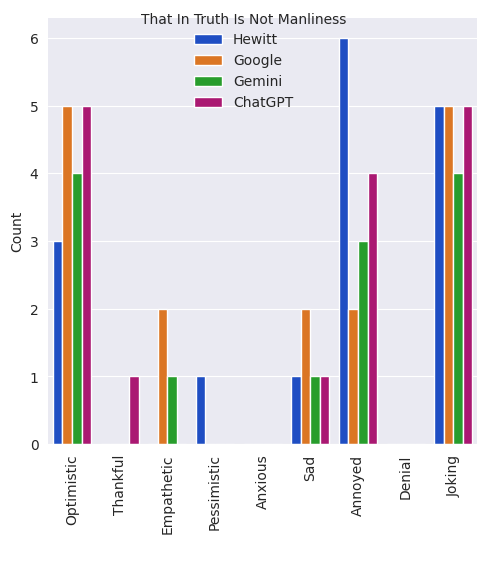

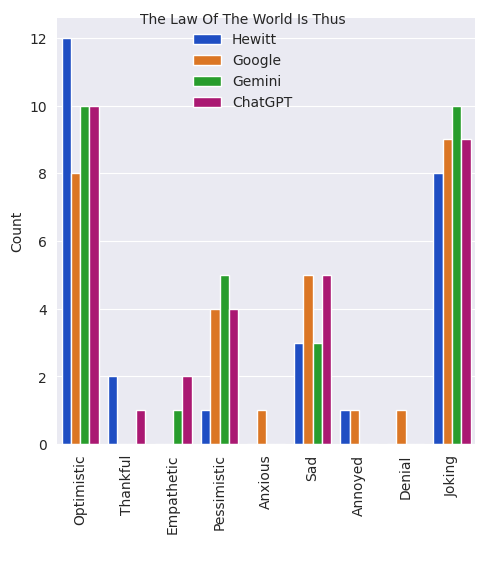

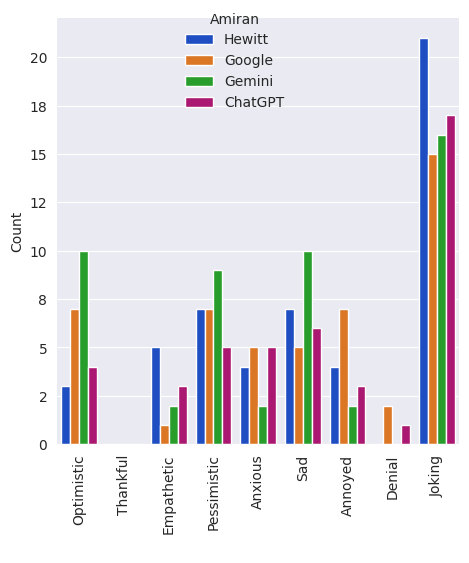

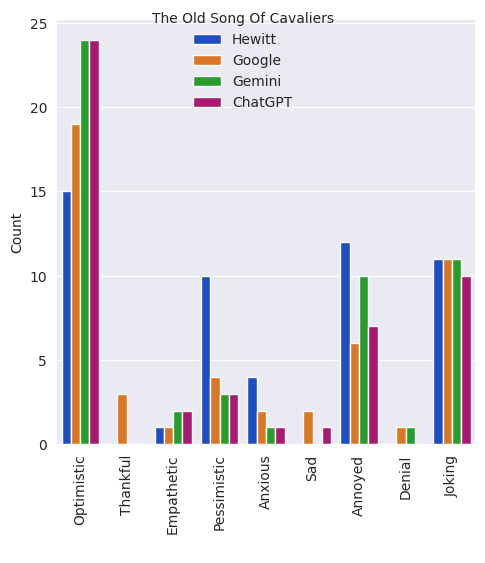

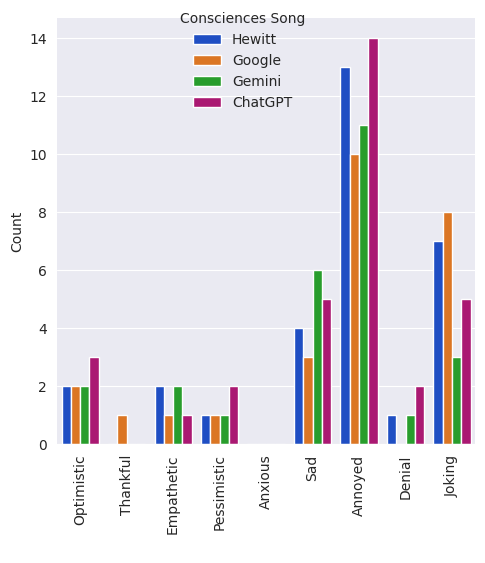

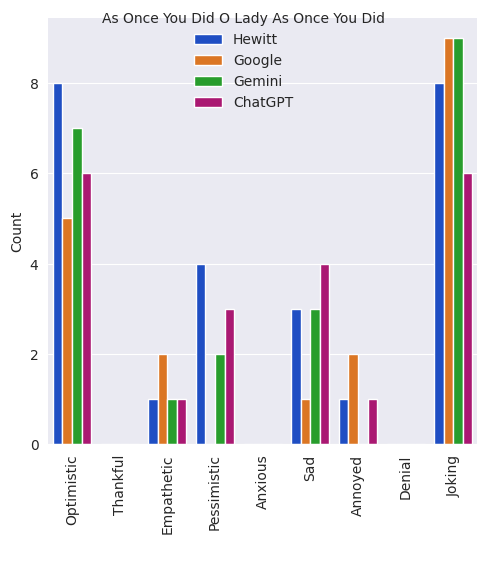

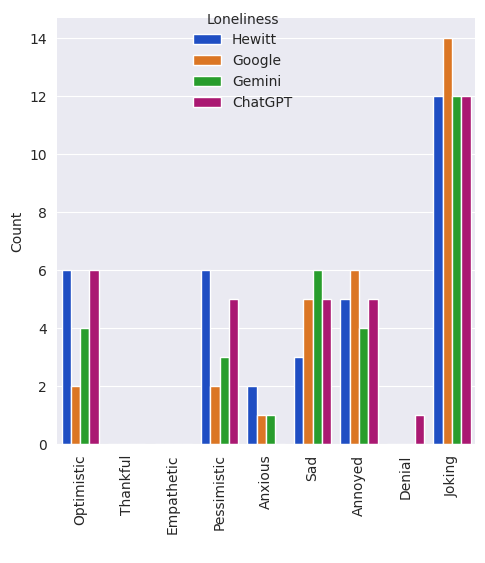

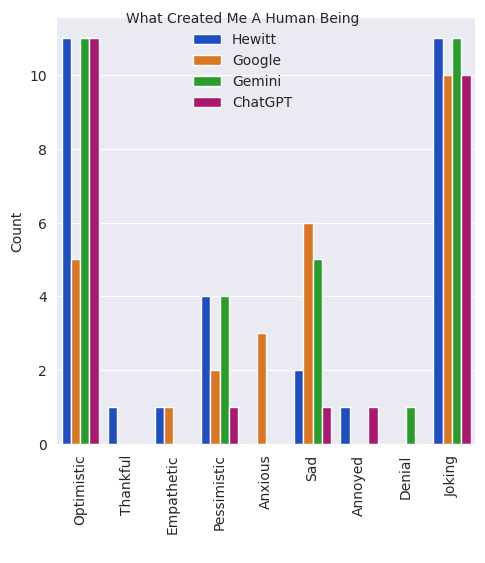

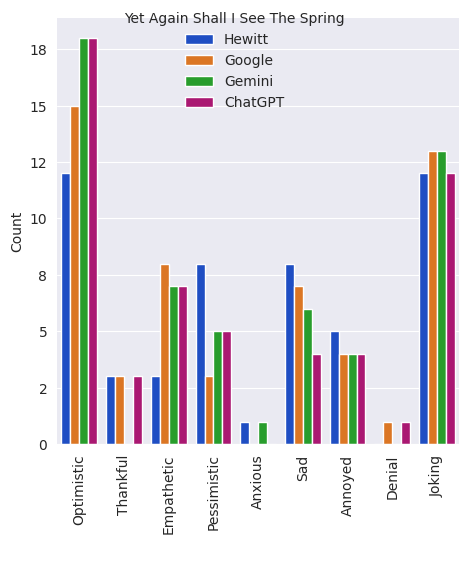

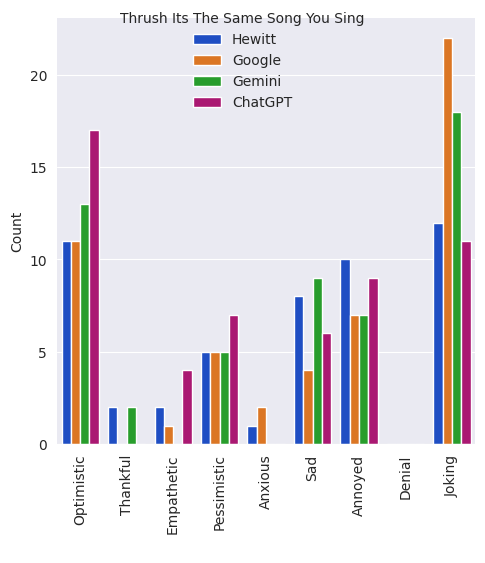

In [23]:
for poem in poem_names:
    hewitt_df = chapter_wise_dataframe('en/', poem)
    google_df = chapter_wise_dataframe('ggl/', poem)
    gemini_df = chapter_wise_dataframe('gem/', poem)
    chatgpt_df =chapter_wise_dataframe('gpt/', poem)
    df_new = pd.concat(
        [
            hewitt_df, 
            google_df['Count'], 
            gemini_df['Count'], 
            chatgpt_df['Count']
        ], 
        axis=1
    )

    df_new.columns = ['Hewitt', 'Google', 'Gemini', 'ChatGPT']
    df_new = df_new.reset_index()
    df_new = df_new.rename(columns={"index":"Sentiment"})
    df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
    colors = ["blue", "orange", "green","magenta"]  
    myPalette = sns.xkcd_palette(colors)

    sns.set_style("darkgrid")
    g = sns.catplot(
        x='Sentiment', 
        y='Count', 
        hue='Author', 
        data=df_new, 
        kind='bar', 
        palette=myPalette, 
        legend=True
    )
    g.despine(left=True)

    sns.move_legend(g, 'upper center', title=poem[3:-3].replace('_', ' ').title())    
    plt.ylabel('Count')
    plt.xlabel(' ')
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.yticks()
    plt.xticks()
    plt.xticks(rotation=90)

In [24]:
df_new.head()

Sentiment  Author  Count
0   Optimistic  Hewitt   11.0
1     Thankful  Hewitt    2.0
2   Empathetic  Hewitt    2.0
3  Pessimistic  Hewitt    5.0
4      Anxious  Hewitt    1.0

In [25]:
df_new.reset_index()

index    Sentiment   Author  Count
0       0   Optimistic   Hewitt   11.0
1       1     Thankful   Hewitt    2.0
2       2   Empathetic   Hewitt    2.0
3       3  Pessimistic   Hewitt    5.0
4       4      Anxious   Hewitt    1.0
5       5          Sad   Hewitt    8.0
6       6      Annoyed   Hewitt   10.0
7       7       Denial   Hewitt    0.0
8       8       Joking   Hewitt   12.0
9       9   Optimistic   Google   11.0
10     10     Thankful   Google    0.0
11     11   Empathetic   Google    1.0
12     12  Pessimistic   Google    5.0
13     13      Anxious   Google    2.0
14     14          Sad   Google    4.0
15     15      Annoyed   Google    7.0
16     16       Denial   Google    0.0
17     17       Joking   Google   22.0
18     18   Optimistic   Gemini   13.0
19     19     Thankful   Gemini    2.0
20     20   Empathetic   Gemini    0.0
21     21  Pessimistic   Gemini    5.0
22     22      Anxious   Gemini    0.0
23     23          Sad   Gemini    9.0
24     24      Annoyed   Gemini    7.0
25     25       Denial   Gemini    0.0
26     26       Joking   Gemini   18.0
27     27   Optimistic  ChatGPT   17.0
28     28     Thankful  ChatGPT    0.0
29     29   Empathetic  ChatGPT    4.0
30     30  Pessimistic  ChatGPT    7.0
31     31      Anxious  ChatGPT    0.0
32     32          Sad  ChatGPT    6.0
33     33      Annoyed  ChatGPT    9.0
34     34       Denial  ChatGPT    0.0
35     35       Joking  ChatGPT   11.0

<Axes: >

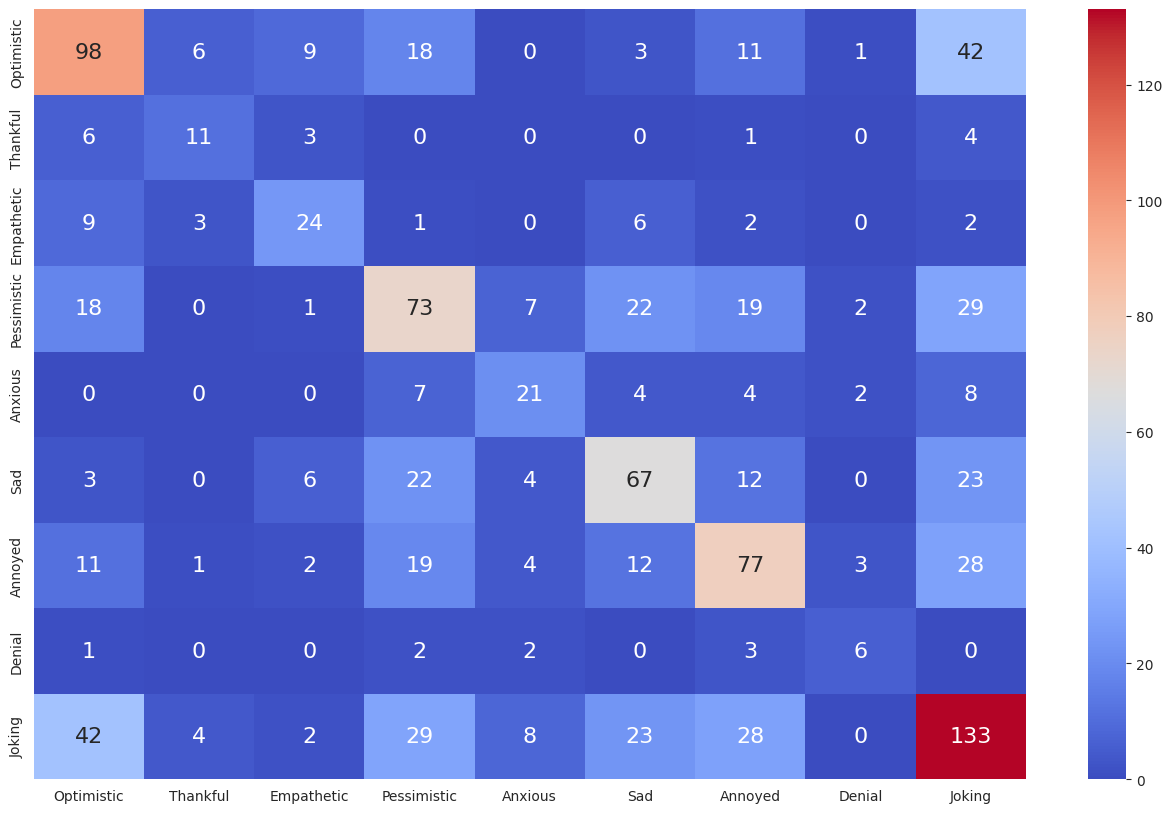

In [26]:
heatmap_df = pd.read_csv('sentiment/en/' + poem_names[0])
heatmap_df = heatmap_df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)

for poem in poem_names[1:]:
  df = pd.read_csv('sentiment/en/' + poem)
  df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
  heatmap_df = pd.concat([heatmap_df, df], axis=0)

emote_array = np.zeros((9, 9))
e2i = {'Optimistic': 0, 'Thankful': 1, 'Empathetic': 2, 'Pessimistic': 3, 'Anxious': 4, 'Sad': 5, 'Annoyed': 6, 'Denial': 7, 'Joking': 8}

for i in range(len(heatmap_df)):
    l = heatmap_df.iloc[i].tolist()
    for j in range(9):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 9):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

emotions = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']
emote_df = pd.DataFrame(emote_array, columns=emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)

fig = plt.figure(figsize = (16, 10))
sns.heatmap(emote_df, annot=True, cmap='coolwarm', xticklabels=emote_df.columns, yticklabels=emote_df.columns, fmt='g', annot_kws={"size": 16})

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Optimistic'),
  Text(1, 0, 'Thankful'),
  Text(2, 0, 'Empathetic'),
  Text(3, 0, 'Pessimistic'),
  Text(4, 0, 'Anxious'),
  Text(5, 0, 'Sad'),
  Text(6, 0, 'Annoyed'),
  Text(7, 0, 'Denial'),
  Text(8, 0, 'Joking')])

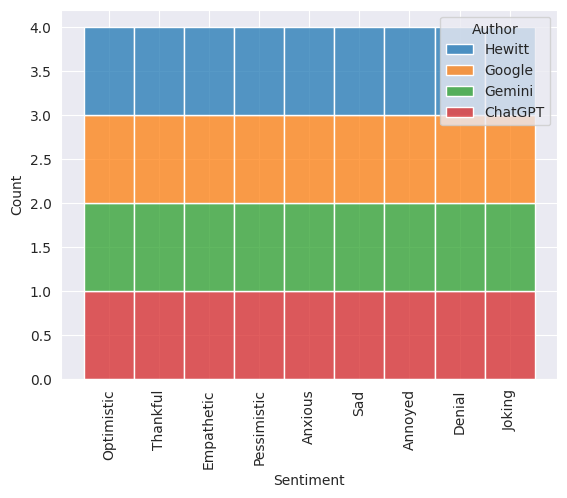

In [27]:
hewitt_sentiment = all_chapter_dataframe('en/')
google_sentiment = all_chapter_dataframe('ggl/')
gemini_sentiment = all_chapter_dataframe('gem/')
chatgpt_sentiment = all_chapter_dataframe('gpt/')

df_new = pd.concat([hewitt_sentiment, google_sentiment['Count'], gemini_sentiment['Count'], chatgpt_sentiment['Count']], axis=1)
df_new.columns = ['Sentiment', 'Hewitt', 'Google', 'Gemini', 'ChatGPT'] 
df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
sns.histplot(data=df_new, x='Sentiment', hue='Author', multiple='stack')
plt.xticks(rotation=90)

In [28]:
df_new.head()

Sentiment  Author  Count
0   Optimistic  Hewitt     98
1     Thankful  Hewitt     11
2   Empathetic  Hewitt     24
3  Pessimistic  Hewitt     73
4      Anxious  Hewitt     21

In [29]:
hewitt_poem_01 = pd.read_csv('sentiment/en/' + poem_names[0])
google_poem_01 = pd.read_csv('sentiment/ggl/' + poem_names[0])
gemini_poem_01 = pd.read_csv('sentiment/gem/' + poem_names[0])
chatgpt_poem_01 = pd.read_csv('sentiment/gpt/' + poem_names[0])

hewitt_poem_01_short = hewitt_poem_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
google_poem_01_short = google_poem_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
gemini_poem_01_short = gemini_poem_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
chatgpt_poem_01_short = chatgpt_poem_01.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

In [30]:
hewitt_poem_01

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   

                                                                                                                                              Tweet  \
0      I believe, I always have believed In the eternal life of the soul, The good, the lover of the world, Scarred by the fate of this same world.   
1  I believe that, though the ashes of kind hearts Be scattered over the land by the wind, Yet in each of us there will burn Hotly a wish forlorn —   
2                        To repress evil, and that this Will ever be a defence of the good, Help, succour and saviour Of the downtrodden and needy.   
3                                        Nature does not totally extinguish a kind heart, She carries it along with her from the very dawn of time.   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
2         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
3         1.0       0.0         0.0          0.0      0.0  0.0      0.0   

   Denial  Official report  Joking  
0     0.0              0.0     0.0  
1     0.0              0.0     0.0  
2     0.0              0.0     0.0  
3     0.0              0.0     0.0

In [31]:
google_poem_01


Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   

                                                                                                                                Tweet  \
0                I believe, there are always lands eternal life of the soul, Good, country lover, Ulcer from the fate of the country.   
1  I believe that ashes are the heart of a good person Let the wind scatter the land, It still burns in itself Tial-desire was hot, –   
2                                 Evil oppressor, good There will always be a guard; Bechav, needy He helped me, helped me, saved me.   
3                                                                       Nature does not kill a good heart Brings old things with him!   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         0.0          0.0      0.0  0.0      1.0   
1         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
2         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
3         1.0       0.0         0.0          0.0      0.0  0.0      0.0   

   Denial  Official report  Joking  
0     0.0              0.0     0.0  
1     0.0              0.0     1.0  
2     0.0              0.0     0.0  
3     0.0              0.0     0.0

In [32]:
gemini_poem_01

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   

                                                                                                                                            Tweet  \
0   I believe, I've always believed In the eternal life of the soul, Of the good, the lover of the country, The one pained by the country's fate.   
1  I believe, even when the ashes Of a good heart are scattered by the wind, Within each one, a spark still ignites, A burning desire for warmth.   
2                 To suppress evil, to protect the good, It will always be a guardian; For the poor, the troubled, A helper, a savior, a rescuer.   
3                                                                   Nature does not kill a good heart, It carries it along, from time immemorial!   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         1.0       1.0         0.0          0.0      0.0  0.0      0.0   
3         1.0       0.0         0.0          0.0      0.0  0.0      0.0   

   Denial  Official report  Joking  
0     0.0              0.0     0.0  
1     0.0              0.0     0.0  
2     0.0              0.0     0.0  
3     0.0              0.0     0.0

In [33]:
chatgpt_poem_01

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   

                                                                                                                                                        Tweet  \
0  I believe, I have always believed in the eternal life of the soul, of the good, the lover of the homeland, the one suffering from the fate of the country.   
1                              I believe, that even if the ashes of a good heart are scattered by the wind, they will still ignite a burning desire within, —   
2                       as the protector against evil, the good will always be a guardian; for the helpless, the downtrodden a helper, a supporter, a savior.   
3                                                                                   Nature does not kill a good heart, it carries the wisdom of the ancients!   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
3         1.0       0.0         0.0          0.0      0.0  0.0      0.0   

   Denial  Official report  Joking  
0     0.0              0.0     0.0  
1     0.0              0.0     1.0  
2     0.0              0.0     0.0  
3     0.0              0.0     0.0

In [34]:
y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])

In [35]:
for ii in range(0, hewitt_poem_01_short.shape[0]):
    print(jaccard_score(google_poem_01_short.iloc[ii, :], hewitt_poem_01_short.iloc[ii, :]))

0.3333333333333333
0.6666666666666666
1.0
1.0


In [36]:
hewitt_ggl_df = pd.DataFrame()
hewitt_gem_df = pd.DataFrame()
hewitt_gpt_df = pd.DataFrame()

poem_list = []
hewitt_ggl_lst = []
hewitt_gem_lst = []
hewitt_gpt_lst = []

ggl = []
gem = []
gpt = []

sum1 = 0
sum2 = 0
sum3 = 0

for poem in poem_names:
    hewitt_df = pd.read_csv('sentiment/' + 'en/' + poem)
    google_df = pd.read_csv('sentiment/' + 'ggl/' + poem)
    gemini_df = pd.read_csv('sentiment/' + 'gem/' + poem)
    chatgpt_df = pd.read_csv('sentiment/' + 'gpt/' + poem)

    hewitt_df = hewitt_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    google_df = google_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    gemini_df = gemini_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
    chatgpt_df = chatgpt_df.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

    for ii in range(0, hewitt_df.shape[0]):
        hewitt_ggl_lst.append(jaccard_score(hewitt_df.iloc[ii, :], google_df.iloc[ii, :]))
        hewitt_gem_lst.append(jaccard_score(hewitt_df.iloc[ii, :], gemini_df.iloc[ii, :]))
        hewitt_gpt_lst.append(jaccard_score(hewitt_df.iloc[ii, :], chatgpt_df.iloc[ii, :]))

    poem_list.append(poem)

    hewitt_ggl_df1 = pd.DataFrame(poem_list, columns=['Poem'])
    hewitt_ggl_df2 = pd.DataFrame(hewitt_ggl_lst, columns=['Hewitt - Google'])
    hewitt_ggl_df  = pd.concat([hewitt_ggl_df1, hewitt_ggl_df2], axis=1)

    hewitt_gem_df1 = pd.DataFrame(poem_list, columns=['Poem'])
    hewitt_gem_df2 = pd.DataFrame(hewitt_gem_lst, columns=['Hewitt - Gemini'])
    hewitt_gem_df  = pd.concat([hewitt_gem_df1, hewitt_gem_df2], axis=1)

    hewitt_gpt_df1 = pd.DataFrame(poem_list, columns=['Poem'])
    hewitt_gpt_df2 = pd.DataFrame(hewitt_gpt_lst, columns=['Hewitt - ChatGPT'])
    hewitt_gpt_df  = pd.concat([hewitt_gpt_df1, hewitt_gpt_df2], axis=1)    

    ggl.append(hewitt_ggl_df['Hewitt - Google'].mean())
    hewitt_ggl_df3 = pd.DataFrame(ggl, columns=['Hewitt - Google'])
    hewitt_ggl_df4 = pd.concat([hewitt_ggl_df1, hewitt_ggl_df3], axis=1)

    gem.append(hewitt_gem_df['Hewitt - Gemini'].mean())
    hewitt_gem_df3 = pd.DataFrame(gem, columns=['Hewitt - Gemini'])
    hewitt_gem_df4 = pd.concat([hewitt_gem_df1, hewitt_gem_df3], axis=1)

    gpt.append(hewitt_gpt_df['Hewitt - ChatGPT'].mean())
    hewitt_gpt_df3 = pd.DataFrame(gpt, columns=['Hewitt - ChatGPT'])
    hewitt_gpt_df4 = pd.concat([hewitt_gpt_df1, hewitt_gpt_df3], axis=1)

    print('Poem "', str(poem[3:-3].replace('_', ' ').title()), '" Average')
    print('Hewitt - Google ', hewitt_ggl_df['Hewitt - Google'].mean())
    print('Hewitt - Gemini ', hewitt_gem_df['Hewitt - Gemini'].mean())
    print('Hewitt - ChatGPT ', hewitt_gpt_df['Hewitt - ChatGPT'].mean())
    print('\n')

    sum1 += hewitt_ggl_df['Hewitt - Google'].mean()
    sum2 += hewitt_gem_df['Hewitt - Gemini'].mean()
    sum3 += hewitt_gpt_df['Hewitt - ChatGPT'].mean()    


Poem " I Believe I Always Have Believed " Average
Hewitt - Google  0.75
Hewitt - Gemini  0.75
Hewitt - ChatGPT  0.7083333333333333


Poem " Bakur " Average
Hewitt - Google  0.4333333333333333
Hewitt - Gemini  0.4375
Hewitt - ChatGPT  0.4487500000000001


Poem " Some Day It Will Happen I Shall Die " Average
Hewitt - Google  0.4523809523809524
Hewitt - Gemini  0.4666666666666667
Hewitt - ChatGPT  0.49217687074829936


Poem " I Feel Like Singing And I Shall Sing " Average
Hewitt - Google  0.4378306878306878
Hewitt - Gemini  0.478042328042328
Hewitt - ChatGPT  0.5177248677248677


Poem " Voice From The Grave " Average
Hewitt - Google  0.41769547325102885
Hewitt - Gemini  0.47860082304526746
Hewitt - ChatGPT  0.5096707818930042


Poem " That In Truth Is Not Manliness " Average
Hewitt - Google  0.4130036630036629
Hewitt - Gemini  0.4681318681318681
Hewitt - ChatGPT  0.5012820512820513


Poem " The Law Of The World Is Thus " Average
Hewitt - Google  0.4367283950617284
Hewitt - Gemini  0.48935

In [37]:
sum1 = sum1 / len(poem_names)
sum2 = sum2 / len(poem_names)
sum3 = sum3 / len(poem_names)

print('sum1 ', sum1)
print('sum2 ', sum2)
print('sum3 ', sum3)

sum1  0.4544626749892032
sum2  0.5122116387430807
sum3  0.523586948689995


In [38]:
hewitt_ggl_df1 = pd.DataFrame(poem_list, columns=['Poem'])
hewitt_ggl_df2 = pd.DataFrame(hewitt_ggl_df4, columns=['Hewitt - Google'])
hewitt_ggl_df = pd.concat([hewitt_ggl_df1, hewitt_ggl_df2], axis=1)
hewitt_ggl_df

Poem  Hewitt - Google
0         01_i_believe_i_always_have_believed.md         0.750000
1                                    02_bakur.md         0.433333
2      03_some_day_it_will_happen_i_shall_die.md         0.452381
3     04_i_feel_like_singing_and_i_shall_sing.md         0.437831
4                     05_voice_from_the_grave.md         0.417695
5           06_that_in_truth_is_not_manliness.md         0.413004
6             07_the_law_of_the_world_is_thus.md         0.436728
7                                   08_amiran.md         0.402024
8                09_the_old_song_of_cavaliers.md         0.419724
9                         10_consciences_song.md         0.427957
10  11_as_once_you_did_o_lady_as_once_you_did.md         0.433586
11                              12_loneliness.md         0.454341
12           13_what_created_me_a_human_being.md         0.446449
13        14_yet_again_shall_i_see_the_spring.md         0.445266
14       15_thrush_its_the_same_song_you_sing.md         0.446621

In [39]:
df_final = pd.concat([hewitt_ggl_df, hewitt_gem_df3['Hewitt - Gemini'], hewitt_gpt_df3['Hewitt - ChatGPT']], axis=1)
df_final

Poem  Hewitt - Google  \
0         01_i_believe_i_always_have_believed.md         0.750000   
1                                    02_bakur.md         0.433333   
2      03_some_day_it_will_happen_i_shall_die.md         0.452381   
3     04_i_feel_like_singing_and_i_shall_sing.md         0.437831   
4                     05_voice_from_the_grave.md         0.417695   
5           06_that_in_truth_is_not_manliness.md         0.413004   
6             07_the_law_of_the_world_is_thus.md         0.436728   
7                                   08_amiran.md         0.402024   
8                09_the_old_song_of_cavaliers.md         0.419724   
9                         10_consciences_song.md         0.427957   
10  11_as_once_you_did_o_lady_as_once_you_did.md         0.433586   
11                              12_loneliness.md         0.454341   
12           13_what_created_me_a_human_being.md         0.446449   
13        14_yet_again_shall_i_see_the_spring.md         0.445266   
14       15_thrush_its_the_same_song_you_sing.md         0.446621   

    Hewitt - Gemini  Hewitt - ChatGPT  
0          0.750000          0.708333  
1          0.437500          0.448750  
2          0.466667          0.492177  
3          0.478042          0.517725  
4          0.478601          0.509671  
5          0.468132          0.501282  
6          0.489352          0.509568  
7          0.485833          0.493095  
8          0.492209          0.501183  
9          0.511290          0.512724  
10         0.522391          0.515320  
11         0.532248          0.535039  
12         0.531232          0.540000  
13         0.522438          0.539040  
14         0.517239          0.529897

In [40]:
hewitt_ggl_avg_score = df_final['Hewitt - Google'].mean()
hewitt_gem_avg_score = df_final['Hewitt - Gemini'].mean()
hewitt_gpt_avg_score = df_final['Hewitt - ChatGPT'].mean()

print(hewitt_ggl_avg_score)
print(hewitt_gem_avg_score)
print(hewitt_gpt_avg_score)

0.45446267498920323
0.5122116387430806
0.5235869486899948


In [41]:
data = pd.melt(df_final, ['Poem'])

In [42]:
data

Poem          variable     value
0         01_i_believe_i_always_have_believed.md   Hewitt - Google  0.750000
1                                    02_bakur.md   Hewitt - Google  0.433333
2      03_some_day_it_will_happen_i_shall_die.md   Hewitt - Google  0.452381
3     04_i_feel_like_singing_and_i_shall_sing.md   Hewitt - Google  0.437831
4                     05_voice_from_the_grave.md   Hewitt - Google  0.417695
5           06_that_in_truth_is_not_manliness.md   Hewitt - Google  0.413004
6             07_the_law_of_the_world_is_thus.md   Hewitt - Google  0.436728
7                                   08_amiran.md   Hewitt - Google  0.402024
8                09_the_old_song_of_cavaliers.md   Hewitt - Google  0.419724
9                         10_consciences_song.md   Hewitt - Google  0.427957
10  11_as_once_you_did_o_lady_as_once_you_did.md   Hewitt - Google  0.433586
11                              12_loneliness.md   Hewitt - Google  0.454341
12           13_what_created_me_a_human_being.md   Hewitt - Google  0.446449
13        14_yet_again_shall_i_see_the_spring.md   Hewitt - Google  0.445266
14       15_thrush_its_the_same_song_you_sing.md   Hewitt - Google  0.446621
15        01_i_believe_i_always_have_believed.md   Hewitt - Gemini  0.750000
16                                   02_bakur.md   Hewitt - Gemini  0.437500
17     03_some_day_it_will_happen_i_shall_die.md   Hewitt - Gemini  0.466667
18    04_i_feel_like_singing_and_i_shall_sing.md   Hewitt - Gemini  0.478042
19                    05_voice_from_the_grave.md   Hewitt - Gemini  0.478601
20          06_that_in_truth_is_not_manliness.md   Hewitt - Gemini  0.468132
21            07_the_law_of_the_world_is_thus.md   Hewitt - Gemini  0.489352
22                                  08_amiran.md   Hewitt - Gemini  0.485833
23               09_the_old_song_of_cavaliers.md   Hewitt - Gemini  0.492209
24                        10_consciences_song.md   Hewitt - Gemini  0.511290
25  11_as_once_you_did_o_lady_as_once_you_did.md   Hewitt - Gemini  0.522391
26                              12_loneliness.md   Hewitt - Gemini  0.532248
27           13_what_created_me_a_human_being.md   Hewitt - Gemini  0.531232
28        14_yet_again_shall_i_see_the_spring.md   Hewitt - Gemini  0.522438
29       15_thrush_its_the_same_song_you_sing.md   Hewitt - Gemini  0.517239
30        01_i_believe_i_always_have_believed.md  Hewitt - ChatGPT  0.708333
31                                   02_bakur.md  Hewitt - ChatGPT  0.448750
32     03_some_day_it_will_happen_i_shall_die.md  Hewitt - ChatGPT  0.492177
33    04_i_feel_like_singing_and_i_shall_sing.md  Hewitt - ChatGPT  0.517725
34                    05_voice_from_the_grave.md  Hewitt - ChatGPT  0.509671
35          06_that_in_truth_is_not_manliness.md  Hewitt - ChatGPT  0.501282
36            07_the_law_of_the_world_is_thus.md  Hewitt - ChatGPT  0.509568
37                                  08_amiran.md  Hewitt - ChatGPT  0.493095
38               09_the_old_song_of_cavaliers.md  Hewitt - ChatGPT  0.501183
39                        10_consciences_song.md  Hewitt - ChatGPT  0.512724
40  11_as_once_you_did_o_lady_as_once_you_did.md  Hewitt - ChatGPT  0.515320
41                              12_loneliness.md  Hewitt - ChatGPT  0.535039
42           13_what_created_me_a_human_being.md  Hewitt - ChatGPT  0.540000
43        14_yet_again_shall_i_see_the_spring.md  Hewitt - ChatGPT  0.539040
44       15_thrush_its_the_same_song_you_sing.md  Hewitt - ChatGPT  0.529897

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, '01_i_believe_i_always_have_believed.md'),
  Text(1, 0, '02_bakur.md'),
  Text(2, 0, '03_some_day_it_will_happen_i_shall_die.md'),
  Text(3, 0, '04_i_feel_like_singing_and_i_shall_sing.md'),
  Text(4, 0, '05_voice_from_the_grave.md'),
  Text(5, 0, '06_that_in_truth_is_not_manliness.md'),
  Text(6, 0, '07_the_law_of_the_world_is_thus.md'),
  Text(7, 0, '08_amiran.md'),
  Text(8, 0, '09_the_old_song_of_cavaliers.md'),
  Text(9, 0, '10_consciences_song.md'),
  Text(10, 0, '11_as_once_you_did_o_lady_as_once_you_did.md'),
  Text(11, 0, '12_loneliness.md'),
  Text(12, 0, '13_what_created_me_a_human_being.md'),
  Text(13, 0, '14_yet_again_shall_i_see_the_spring.md'),
  Text(14, 0, '15_thrush_its_the_same_song_you_sing.md')])

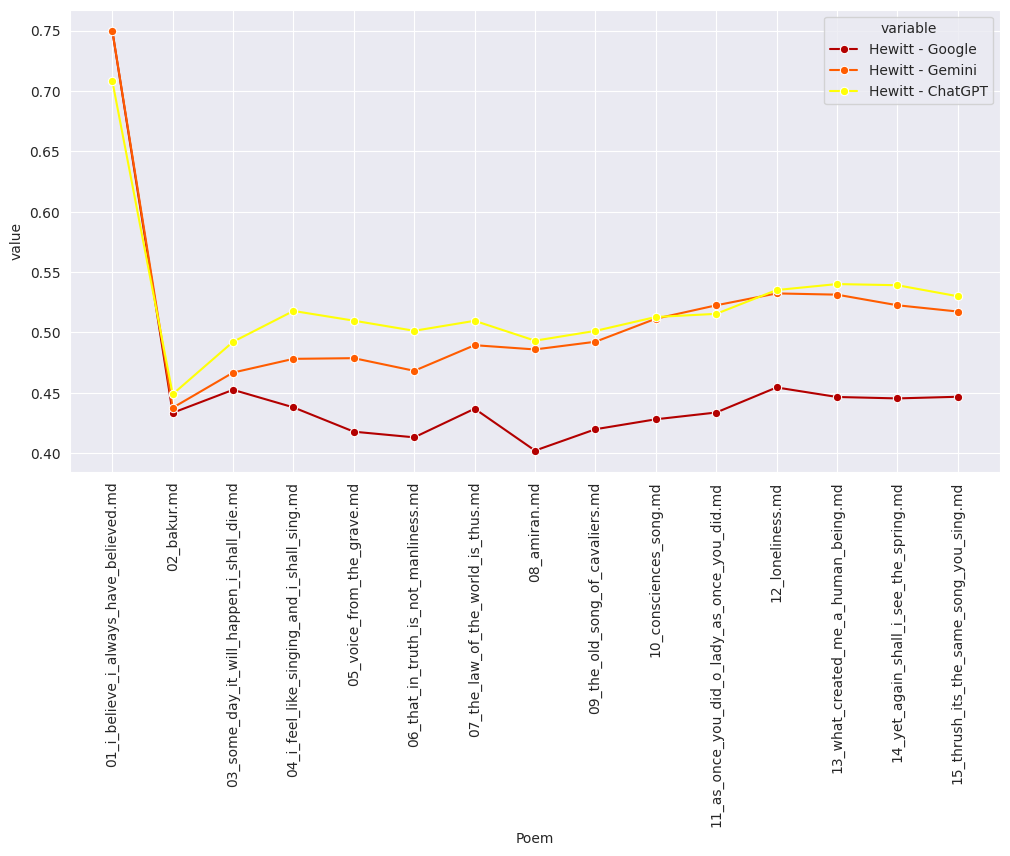

In [44]:
sns.set_style("darkgrid")
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x='Poem', y='value', hue = 'variable', data=data, palette='hot', dashes=False, marker='o', ax=ax)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, '01_i_believe_i_always_have_believed.md'),
  Text(1, 0, '02_bakur.md'),
  Text(2, 0, '03_some_day_it_will_happen_i_shall_die.md'),
  Text(3, 0, '04_i_feel_like_singing_and_i_shall_sing.md'),
  Text(4, 0, '05_voice_from_the_grave.md'),
  Text(5, 0, '06_that_in_truth_is_not_manliness.md'),
  Text(6, 0, '07_the_law_of_the_world_is_thus.md'),
  Text(7, 0, '08_amiran.md'),
  Text(8, 0, '09_the_old_song_of_cavaliers.md'),
  Text(9, 0, '10_consciences_song.md'),
  Text(10, 0, '11_as_once_you_did_o_lady_as_once_you_did.md'),
  Text(11, 0, '12_loneliness.md'),
  Text(12, 0, '13_what_created_me_a_human_being.md'),
  Text(13, 0, '14_yet_again_shall_i_see_the_spring.md'),
  Text(14, 0, '15_thrush_its_the_same_song_you_sing.md')])

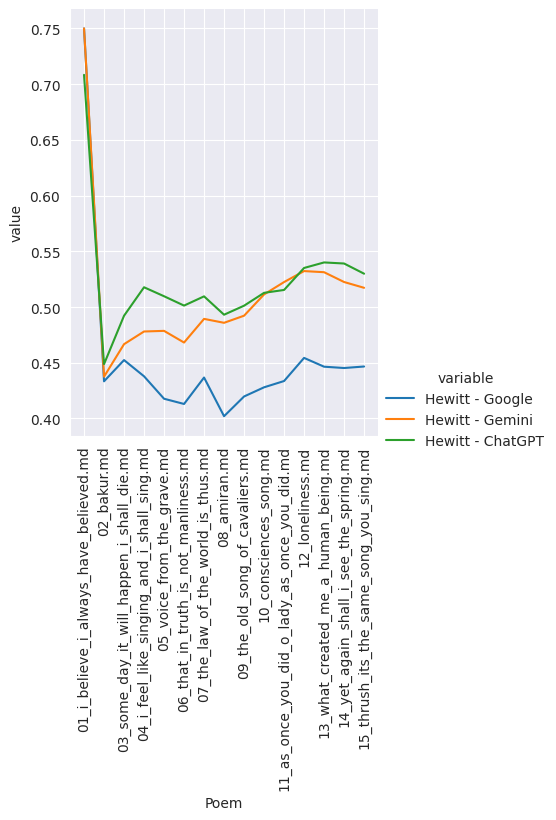

In [45]:
sns.relplot(x="Poem", y="value", hue="variable", dashes=False, markers=True, kind="line", data=data)
plt.xticks(rotation=90)

In [46]:
sentiment_polarity = {
    # 'Surprise': 0,
    'Joking': 0,
    'Pessimistic': -1,
    'Anxious': -1,
    'Sad':  -1,
    'Annoyed': -1,
    'Denial': -1,
    'Optimistic': 1,
    'Thankful': 1,
    'Empathetic': 1
}

In [47]:
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
init_notebook_mode(connected=False)
warnings.filterwarnings("ignore")

In [48]:
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']

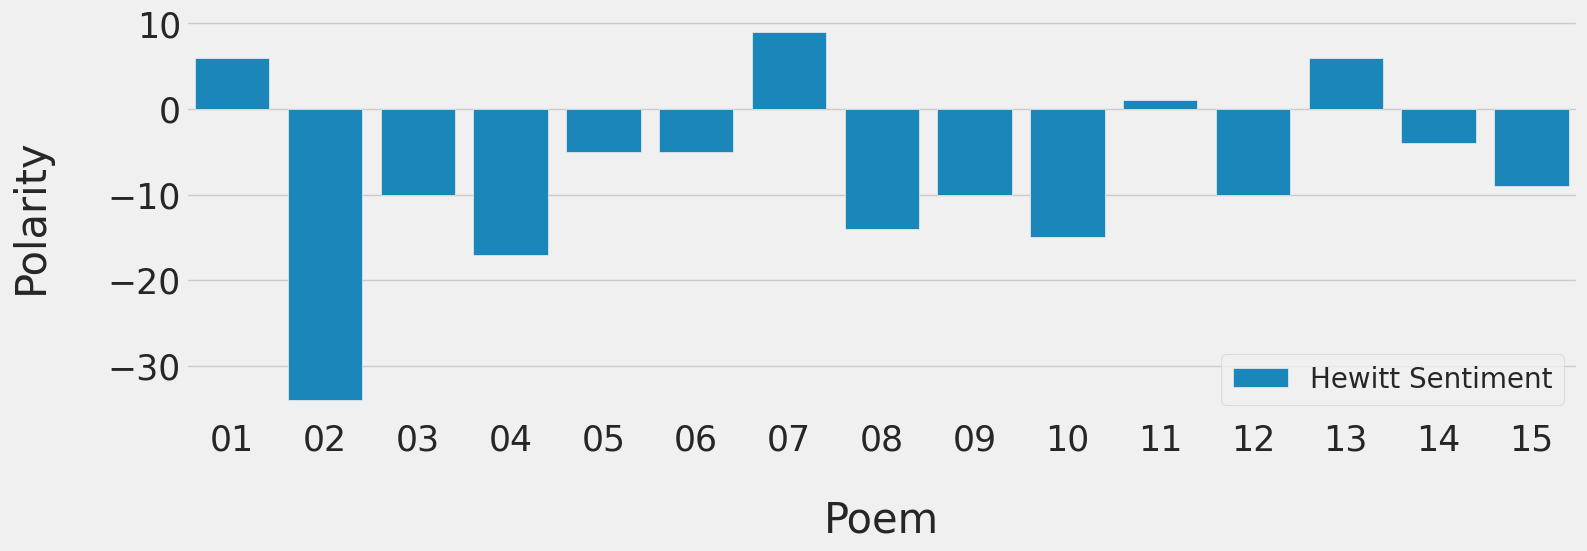

In [50]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Poem', 'Polarity'])

for poem in poem_names:
    df_poem = pd.read_csv('sentiment/' + 'en/' + poem)
    polarity = 0
    for i, row in df_poem.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[poem[:2], polarity]], columns = ['Poem', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Poem')
df_sentiments.reset_index()
df_sentiments.set_index('Poem')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16, 5))
p6 = sns.barplot(x=df_sentiments['Poem'], y=df_sentiments['Polarity'], label='Hewitt Sentiment')
p6.set_xlabel("Hewitt Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Poem', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.show()

In [51]:
def flatten(lst):
    new_list = []
    for sublist in lst:
      if isinstance(sublist, list):
        for item in sublist:
          new_list.append(item)
      else:
        new_list.append(sublist)
    return new_list

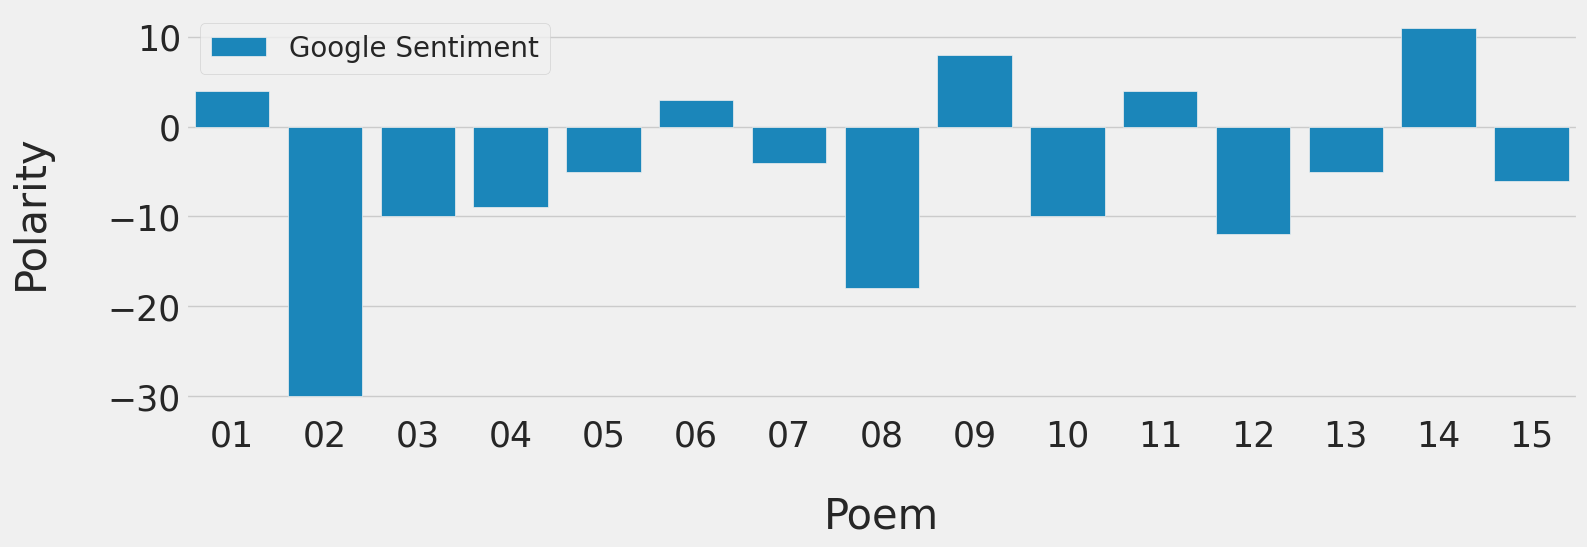

In [52]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Poem', 'Polarity'])

for poem in poem_names:
    df_poem = pd.read_csv('sentiment/' + 'ggl/' + poem)
    polarity = 0
    for i, row in df_poem.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[poem[:2], polarity]], columns = ['Poem', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Poem')
df_sentiments.reset_index()
df_sentiments.set_index('Poem')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Poem'], y=df_sentiments['Polarity'], label='Google Sentiment')
p6.set_xlabel("Google Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Poem', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.show()

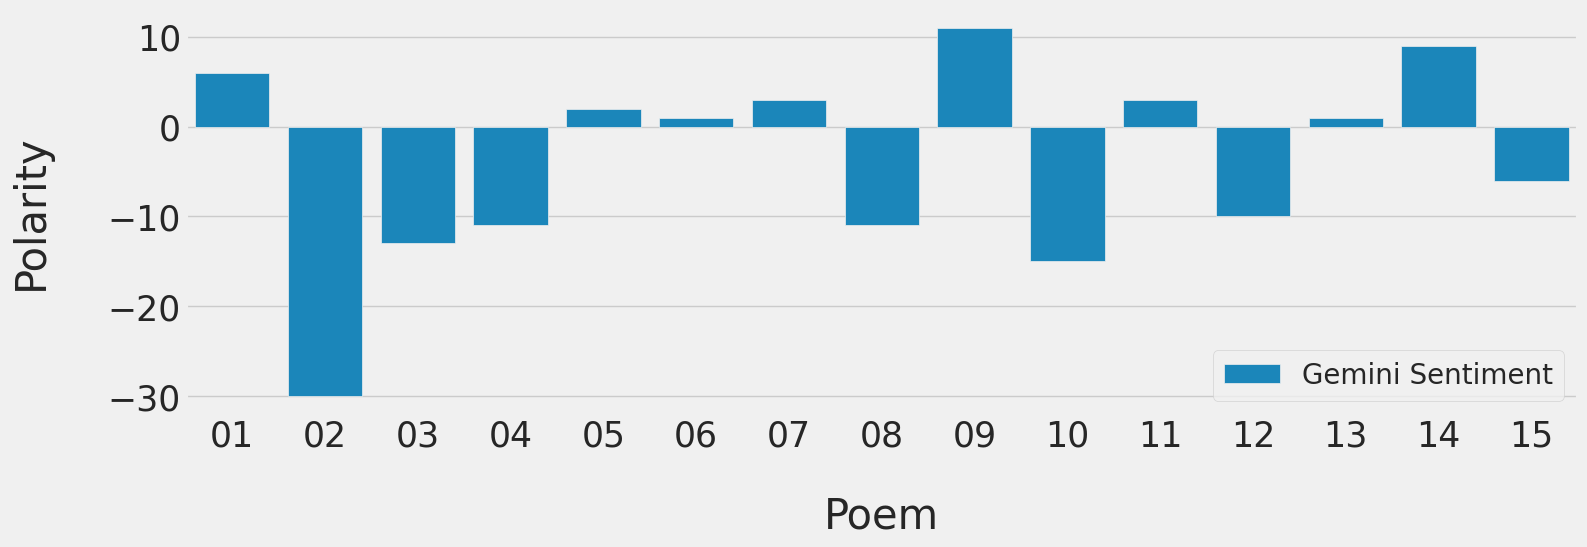

In [53]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Poem', 'Polarity'])

for poem in poem_names:
    df_poem = pd.read_csv('sentiment/' + 'gem/' + poem)
    polarity = 0
    for i, row in df_poem.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[poem[:2], polarity]], columns = ['Poem', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Poem')
df_sentiments.reset_index()
df_sentiments.set_index('Poem')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Poem'], y=df_sentiments['Polarity'], label='Gemini Sentiment')
p6.set_xlabel("Gemini Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Poem', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.show()

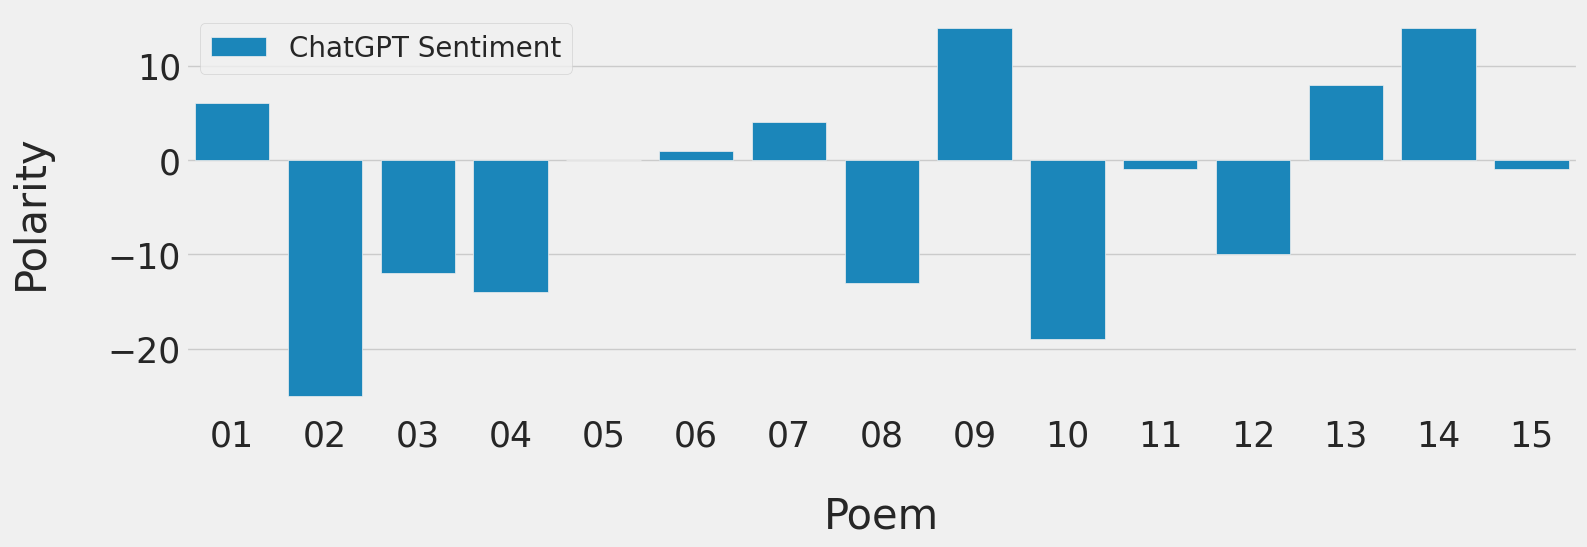

In [54]:
polarity = 0
count = 0
polarity_array = []
df_sentiments = pd.DataFrame(columns=['Poem', 'Polarity'])

for poem in poem_names:
    df_poem = pd.read_csv('sentiment/' + 'gpt/' + poem)
    polarity = 0
    for i, row in df_poem.iterrows():
        if row['Optimistic'] == 1:
            count += 1
            polarity += 1
        if row['Thankful'] == 1:
            count += 1
            polarity += 1
        if row['Empathetic'] == 1:
            count += 1
            polarity += 1
        if row['Denial'] == 1:
            count += 1
            polarity -= 1 
        if row['Annoyed'] == 1:
            count += 1
            polarity -= 1
        if row['Sad'] == 1:
            count += 1
            polarity -= 1
        if row['Anxious'] == 1:
            count += 1
            polarity -= 1
        if row['Pessimistic'] == 1:
            count += 1
            polarity -= 1
        if row['Joking'] == 1:
            polarity += 0

    df_temp = pd.DataFrame([[poem[:2], polarity]], columns = ['Poem', 'Polarity'])
    df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index=True)

df_sentiments = df_sentiments.sort_values('Poem')
df_sentiments.reset_index()
df_sentiments.set_index('Poem')

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.barplot(x=df_sentiments['Poem'], y=df_sentiments['Polarity'], label='ChatGPT Sentiment')
p6.set_xlabel("ChatGPT Sentiment")
plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Poem', labelpad=30, fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(np.arange(0, 15, step=1), fontsize=25)
# plt.xticks(rotation=90)
plt.show()

In [110]:
topic_df = pd.read_csv('sentiment/' + 'gpt/' + poem_names[0])
topic_df = topic_df.drop(['Unnamed: 0', 'Official report'], axis=1)

for poem in poem_names[1:]:
    df = pd.read_csv('sentiment/' + 'gpt/' + poem)
    df = df.drop(['Unnamed: 0', 'Official report'], axis=1)
    topic_df = pd.concat([topic_df, df], axis=0)

topic_df.head()

Tweet  \
0  I believe, I have always believed in the eternal life of the soul, of the good, the lover of the homeland, the one suffering from the fate of the country.   
1                              I believe, that even if the ashes of a good heart are scattered by the wind, they will still ignite a burning desire within, —   
2                       as the protector against evil, the good will always be a guardian; for the helpless, the downtrodden a helper, a supporter, a savior.   
3                                                                                   Nature does not kill a good heart, it carries the wisdom of the ancients!   
0                                                                                                                    Tell us, Elizbar, what happened at Egho?   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
3         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
0         0.0       0.0         0.0          0.0      0.0  1.0      0.0   

   Denial  Joking  
0     0.0     0.0  
1     0.0     1.0  
2     0.0     0.0  
3     0.0     0.0  
0     0.0     0.0

In [111]:
stop_words = stopwords.words('english')
newStopWords = []
stop_words.extend(newStopWords)

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))

def preprocessing(df):
    df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
    df['Tweet'] = df['Tweet'].str.replace(r'[^a-zA-Z#]', ' ', regex=True)                                   # Remove punctuations
    df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
    df['Tweet tokens'] = list(tokenize(df['Tweet']))
    df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
    df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
    return df

def retrieve_text(df):
    doc = '. '.join(df['tokens_no_stop_joined'])
    return doc

def ngrams_series_func(data, n):
    wordList = re.sub("[^\w]", " ",  data).split()
    ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:10]
    return ngrams_series

In [112]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth": 1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center=90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center=0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center=9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [113]:
len(stop_words)

179

In [114]:
topic_df = preprocessing(topic_df)
topic_df.head()

Tweet  \
0  believe have always believed eternal life soul good lover homeland suffering from fate country   
1  believe that even ashes good heart scattered wind they will still ignite burning desire within   
2   protector against evil good will always guardian helpless downtrodden helper supporter savior   
3                                             nature does kill good heart carries wisdom ancients   
0                                                                 tell elizbar what happened egho   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
3         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
0         0.0       0.0         0.0          0.0      0.0  1.0      0.0   

   Denial  Joking  \
0     0.0     0.0   
1     0.0     1.0   
2     0.0     0.0   
3     0.0     0.0   
0     0.0     0.0   

                                                                                                     Tweet tokens  \
0   [believe, have, always, believed, eternal, life, soul, good, lover, homeland, suffering, from, fate, country]   
1  [believe, that, even, ashes, good, heart, scattered, wind, they, will, still, ignite, burning, desire, within]   
2      [protector, against, evil, good, will, always, guardian, helpless, downtrodden, helper, supporter, savior]   
3                                                    [nature, does, kill, good, heart, carries, wisdom, ancients]   
0                                                                           [tell, elizbar, what, happened, egho]   

                                                                                      tokens_no_stop  \
0  [believe, always, believed, eternal, life, soul, good, lover, homeland, suffering, fate, country]   
1       [believe, even, ashes, good, heart, scattered, wind, still, ignite, burning, desire, within]   
2        [protector, evil, good, always, guardian, helpless, downtrodden, helper, supporter, savior]   
3                                             [nature, kill, good, heart, carries, wisdom, ancients]   
0                                                                    [tell, elizbar, happened, egho]   

                                                                  tokens_no_stop_joined  
0  believe always believed eternal life soul good lover homeland suffering fate country  
1       believe even ashes good heart scattered wind still ignite burning desire within  
2      protector evil good always guardian helpless downtrodden helper supporter savior  
3                                        nature kill good heart carries wisdom ancients  
0                                                            tell elizbar happened egho

In [115]:
text = retrieve_text(topic_df)
text.split('. ')

['believe always believed eternal life soul good lover homeland suffering fate country',
 'believe even ashes good heart scattered wind still ignite burning desire within',
 'protector evil good always guardian helpless downtrodden helper supporter savior',
 'nature kill good heart carries wisdom ancients',
 'tell elizbar happened egho',
 'lekians attack bakur fortress yard',
 'want sorrows stirred heart',
 'manhood bakur boast',
 'lives people like swept away grave',
 'lament',
 'truth pride',
 'bear shoulder soul remained sweet',
 'bakur actions wish seen eyes',
 'kills heart fall enemy hands alive',
 'thoughts rise like poison throat',
 'wish lift head straighten back',
 'maybe meant',
 'feel ashamed something shameful',
 'know heard story like rumor wind',
 'blamed thank mentioned badly',
 'enough tell story',
 'large enemy army came surrounded like fence',
 'seven days fought guns killed many',
 'women prepared medicine truly worthy praise',
 'eighth ammunition completely finished

Text(0, 0.5, '')

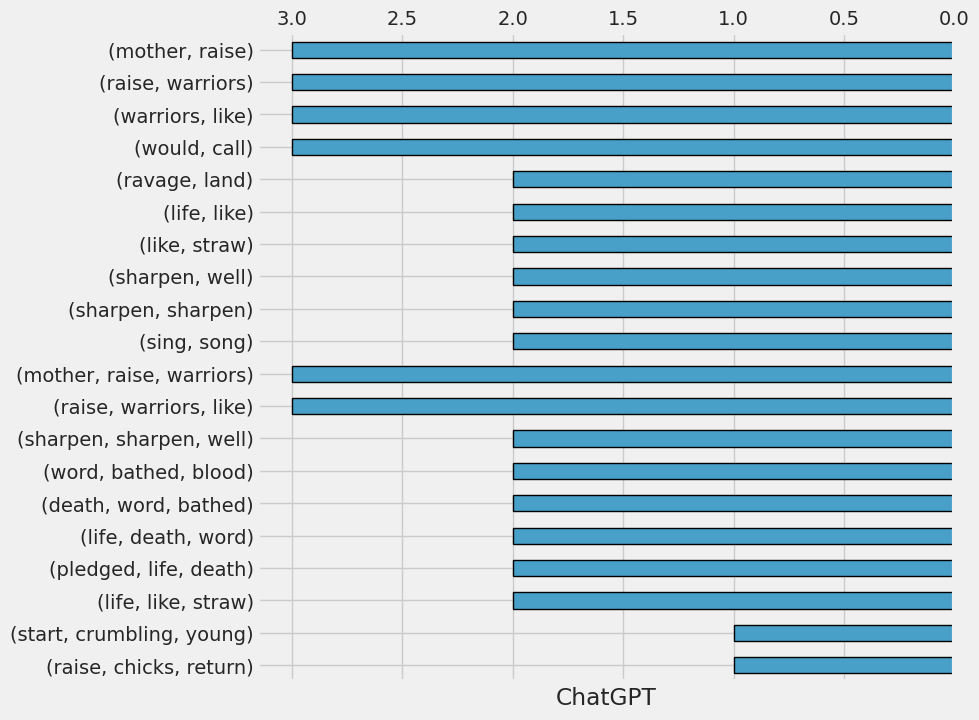

In [117]:
bigram1 = ngrams_series_func(text, 2)
trigram1 = ngrams_series_func(text, 3)
ngram1 = pd.concat([bigram1, trigram1])

plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1,1, figsize=(8,8))
barh_ax = ax

ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3], **barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('ChatGPT')
barh_ax.set_ylabel('', fontsize=50)

In [120]:
topic_df = pd.read_csv('sentiment/' + 'gpt/' + poem_names[0])
topic_df = topic_df.drop(['Unnamed: 0', 'Official report'], axis=1)

for poem in poem_names[1:]:
    df = pd.read_csv('sentiment/' + 'gpt/' + poem)
    df = df.drop(['Unnamed: 0', 'Official report'], axis=1)
    topic_df = pd.concat([topic_df, df], axis=0)

In [121]:
stop_words = stopwords.words('english')

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))

def preprocessing(df):
    df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
    df['Tweet'] = df['Tweet'].str.replace(r'[^a-zA-Z#]', ' ', regex=True)                                   # Remove punctuations
    df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
    df['Tweet tokens'] = list(tokenize(df['Tweet']))
    df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
    df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
    return df

def retrieve_text(df):
    doc = '. '.join(df['tokens_no_stop_joined'])
    return doc

def ngrams_series_func(data, n):
    wordList = re.sub("[^\w]", " ",  data).split()
    ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:10]
    return ngrams_series

In [122]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df, this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)


In [123]:
topic_df = preprocessing(topic_df)
topic_df.head()

Tweet  \
0  believe have always believed eternal life soul good lover homeland suffering from fate country   
1  believe that even ashes good heart scattered wind they will still ignite burning desire within   
2   protector against evil good will always guardian helpless downtrodden helper supporter savior   
3                                             nature does kill good heart carries wisdom ancients   
0                                                                 tell elizbar what happened egho   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
3         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
0         0.0       0.0         0.0          0.0      0.0  1.0      0.0   

   Denial  Joking  \
0     0.0     0.0   
1     0.0     1.0   
2     0.0     0.0   
3     0.0     0.0   
0     0.0     0.0   

                                                                                                     Tweet tokens  \
0   [believe, have, always, believed, eternal, life, soul, good, lover, homeland, suffering, from, fate, country]   
1  [believe, that, even, ashes, good, heart, scattered, wind, they, will, still, ignite, burning, desire, within]   
2      [protector, against, evil, good, will, always, guardian, helpless, downtrodden, helper, supporter, savior]   
3                                                    [nature, does, kill, good, heart, carries, wisdom, ancients]   
0                                                                           [tell, elizbar, what, happened, egho]   

                                                                                      tokens_no_stop  \
0  [believe, always, believed, eternal, life, soul, good, lover, homeland, suffering, fate, country]   
1       [believe, even, ashes, good, heart, scattered, wind, still, ignite, burning, desire, within]   
2        [protector, evil, good, always, guardian, helpless, downtrodden, helper, supporter, savior]   
3                                             [nature, kill, good, heart, carries, wisdom, ancients]   
0                                                                    [tell, elizbar, happened, egho]   

                                                                  tokens_no_stop_joined  
0  believe always believed eternal life soul good lover homeland suffering fate country  
1       believe even ashes good heart scattered wind still ignite burning desire within  
2      protector evil good always guardian helpless downtrodden helper supporter savior  
3                                        nature kill good heart carries wisdom ancients  
0                                                            tell elizbar happened egho

In [124]:
df_optimistic = topic_df[topic_df['Optimistic'] == 1]
df_pessimistic = topic_df[topic_df['Pessimistic'] == 1]
df_denial = topic_df[topic_df['Denial'] == 1]
df_annoyed = topic_df[topic_df['Annoyed'] == 1]
df_thankful = topic_df[topic_df['Thankful'] == 1]
df_empathetic = topic_df[topic_df['Empathetic'] == 1]
df_anxious = topic_df[topic_df['Anxious'] == 1]
df_sad =  topic_df[topic_df['Sad'] == 1]
df_joking = topic_df[topic_df['Joking'] == 1]

In [125]:
text_optimistic = '. '.join(df_optimistic.tokens_no_stop_joined)
text_pessimistic = '. '.join(df_pessimistic.tokens_no_stop_joined)
text_denial = '. '.join(df_denial.tokens_no_stop_joined)
text_annoyed = '. '.join(df_annoyed.tokens_no_stop_joined)
text_thankful = '. '.join(df_thankful.tokens_no_stop_joined)
text_empathetic = '. '.join(df_empathetic.tokens_no_stop_joined)
text_anxious = '. '.join(df_anxious.tokens_no_stop_joined)
text_sad = '. '.join(df_sad.tokens_no_stop_joined)
text_joking = '. '.join(df_joking.tokens_no_stop_joined)

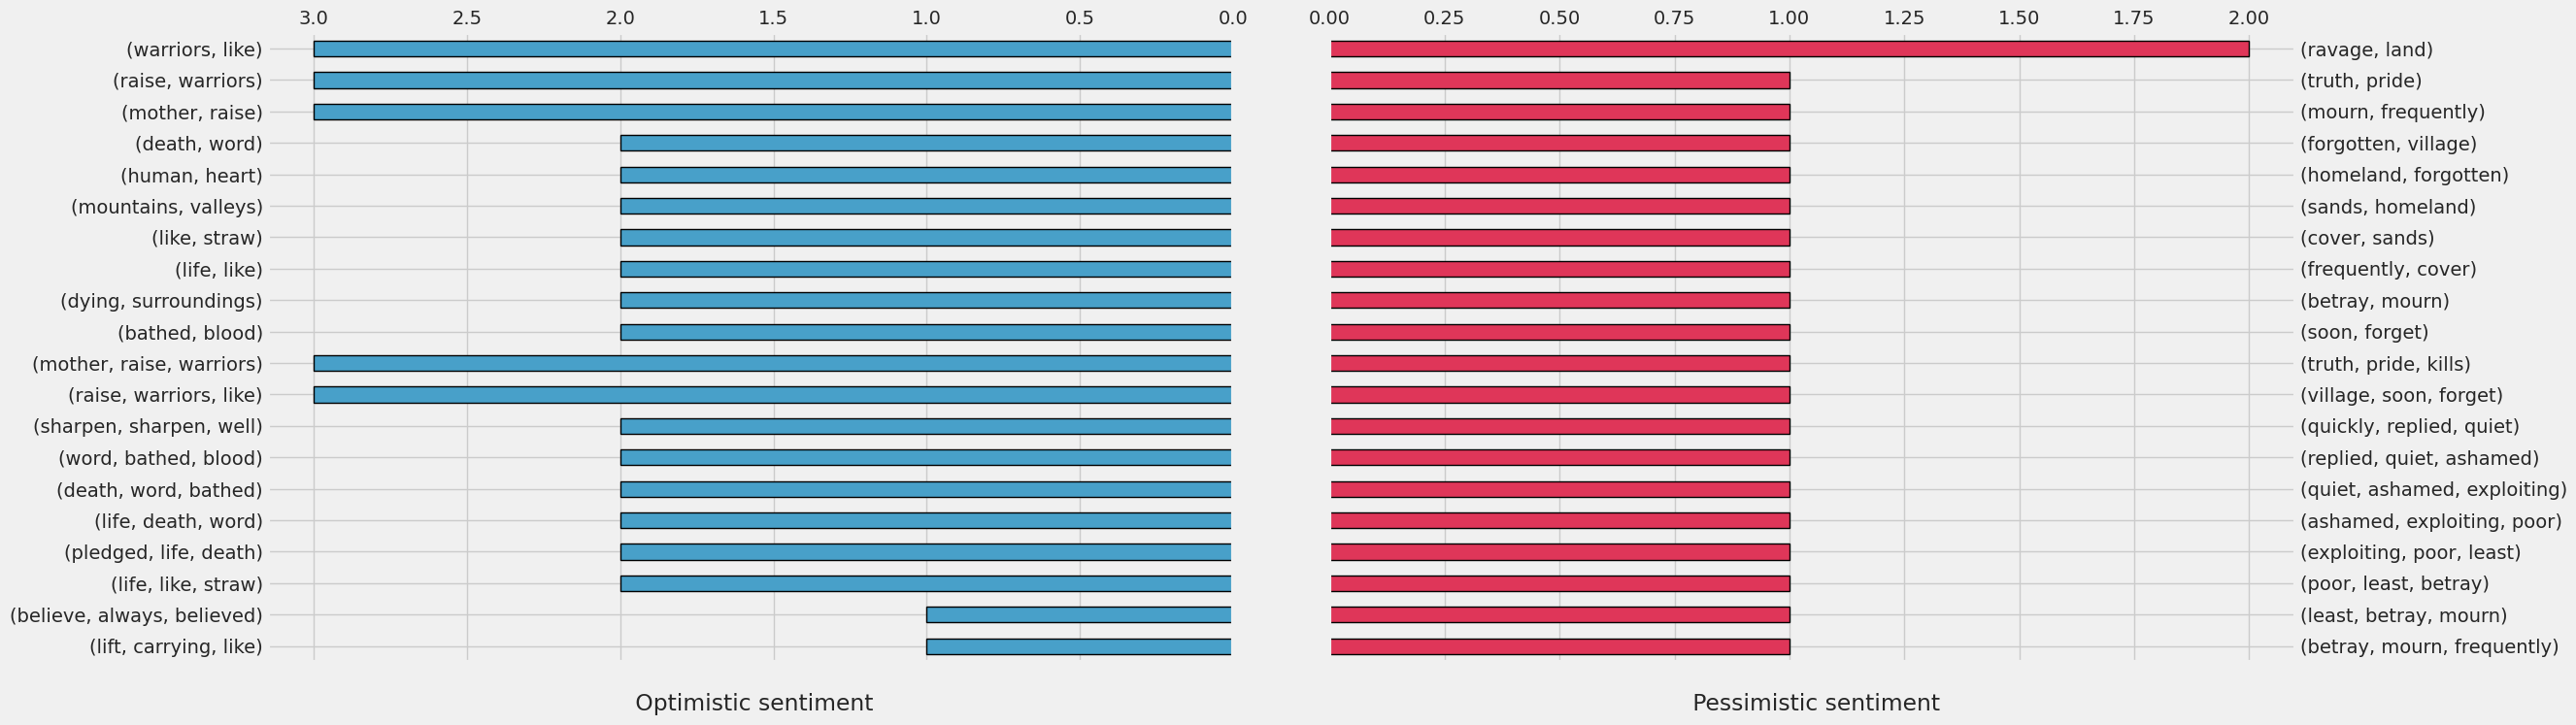

In [126]:
bigram1 = ngrams_series_func(text_optimistic, 2)
trigram1 = ngrams_series_func(text_optimistic, 3)
bigram2 = ngrams_series_func(text_pessimistic, 2)
trigram2 = ngrams_series_func(text_pessimistic, 3)

ngram1 = pd.concat([bigram1, trigram1])
ngram2 = pd.concat([bigram2, trigram2])

plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1, 2, figsize=(24, 8), gridspec_kw = {'width_ratios':[1,1], 'wspace': 0.1, 'hspace': 0.1})

barh_ax = ax[0]
ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3], **barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Optimistic sentiment')
barh_ax.set_ylabel('',fontsize=50)

barh_ax = ax[1]
ngram2[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_ylabel('', fontsize=50)
barh_ax.set_xlabel('\n Pessimistic sentiment')
plt.show()

In [127]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']

def return_sentiments(data, row):
    text = ''
    for sentiment in sentiments:
        if data[sentiment][row] == 1:
            text += sentiment
            text += ', '
    return text

In [130]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']
data = pd.DataFrame(columns=['Poem', 'Verse No.', 'Author', 'Verse', 'Predicted Sentiments', 'Hewitt - Google', 'Hewitt - Gemini', 'Hewitt - ChatGPT'])
count = 0

for poem in poem_names:
    semantic_comparsion = pd.read_csv('results/cosine_similarity.csv')
    
    df_ggl = pd.read_csv('sentiment/' + 'ggl/' + poem)
    df_ggl = df_ggl.drop(['Unnamed: 0', 'Official report'], axis=1)
    df_gem = pd.read_csv('sentiment/' + 'gem/' + poem)
    df_gem = df_gem.drop(['Unnamed: 0', 'Official report'], axis=1)
    df_gpt = pd.read_csv('sentiment/' + 'gpt/' + poem)
    df_gpt = df_gpt.drop(['Unnamed: 0', 'Official report'], axis=1)

    for ii in range(3 * df_ggl.shape[0]):
        
        if ii % 3 == 0:
            pr_sentiments = return_sentiments(df_ggl, ii // 3)
            dict2 = {
                'Poem': [poem], 
                'Verse No.': [ii // 3 + 1], 
                'Author':['Google'],
                'Verse': [df_ggl['Tweet'][ii // 3]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [semantic_comparsion['Hewitt - Google'][ii // 3]], 
                'Hewitt - Gemini': [semantic_comparsion['Hewitt - Gemini'][ii // 3]],
                'Hewitt - ChatGPT': [semantic_comparsion['Hewitt - ChatGPT'][ii // 3]]
            }
            df_temp = pd.DataFrame(dict2)
            data = pd.concat([data, df_temp], ignore_index=True)

        elif ii % 3 == 1:
            pr_sentiments = return_sentiments(df_gem, ii // 3)
            dict2 = {
                'Poem': [' '], 
                'Verse No.': [ii // 3 + 1], 
                'Author':['Gemini'], 
                'Verse': [df_gem['Tweet'][ii // 3]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [' '], 
                'Hewitt - Gemini': [' '],
                'Hewitt - ChatGPT': [' ']
            }
            df_temp = pd.DataFrame(dict2)
            data = pd.concat([data, df_temp], ignore_index=True)

        else:
            pr_sentiments = return_sentiments(df_gpt, ii // 3)
            dict2 = {
                'Poem': [' '], 
                'Verse No.': [ii // 3 + 1], 
                'Author':['ChatGPT'], 
                'Verse': [df_gpt['Tweet'][ii // 3]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [' '], 
                'Hewitt - Gemini': [' '],
                'Hewitt - ChatGPT': [' ']
            }
            df_temp = pd.DataFrame(dict2)
            data=pd.concat([data, df_temp], ignore_index=True)

data

Poem Verse No.   Author  \
0     01_i_believe_i_always_have_believed.md         1   Google   
1                                                    1   Gemini   
2                                                    1  ChatGPT   
3     01_i_believe_i_always_have_believed.md         2   Google   
4                                                    2   Gemini   
..                                       ...       ...      ...   
868                                                 33   Gemini   
869                                                 33  ChatGPT   
870  15_thrush_its_the_same_song_you_sing.md        34   Google   
871                                                 34   Gemini   
872                                                 34  ChatGPT   

                                                                                                                                                          Verse  \
0                                          I believe, there are always lands eternal life of the soul, Good, country lover, Ulcer from the fate of the country.   
1                 I believe, I've always believed In the eternal life of the soul, Of the good, the lover of the country, The one pained by the country's fate.   
2    I believe, I have always believed in the eternal life of the soul, of the good, the lover of the homeland, the one suffering from the fate of the country.   
3                            I believe that ashes are the heart of a good person Let the wind scatter the land, It still burns in itself Tial-desire was hot, –   
4                I believe, even when the ashes Of a good heart are scattered by the wind, Within each one, a spark still ignites, A burning desire for warmth.   
..                                                                                                                                                          ...   
868                                                                                                You don't know the passions of men, Nor why we are broken...   
869                                                                                                        You do not know human passions, nor why we perish...   
870                                                                                                          I miss you in many ways I can't praise you enough!   
871                                                                                                         I miss you in many and in many I cannot praise you!   
872                                                                                                       Many long for you, and many cannot praise you enough!   

                 Predicted Sentiments Hewitt - Google Hewitt - Gemini  \
0               Optimistic, Annoyed,         0.534823        0.741352   
1            Optimistic, Empathetic,                                    
2            Optimistic, Empathetic,                                    
3    Optimistic, Empathetic, Joking,         0.731435        0.758544   
4                        Optimistic,                                    
..                                ...             ...             ...   
868        Pessimistic, Sad, Joking,                                    
869            Pessimistic, Annoyed,                                    
870                             Sad,         0.392336        0.652793   
871                             Sad,                                    
872                    Sad, Annoyed,                                    

    Hewitt - ChatGPT  
0           0.767628  
1                     
2                     
3           0.825588  
4                     
..               ...  
868                   
869                   
870         0.905199  
871                   
872                   

[873 rows x 8 columns]